We pretty much failed with normal regression, but its comprehensible:
- we reduced the number of features available to the model by averaging the cortical thickness
- we are dealing with an inherently difficult problem where the connection may not be trivially linear
- we haven't tried some other approaches in literature (left for you as an excercise)

At this point, it's time for Deep Learning!

We will now try to predict Brain Age based on MRI scans. We will cover
- preprocessing of the scans
- implementation of a possible model
- training, validation
- improvements
- transfer learning

let's go!

In [1]:
# Imports
# General purpose
import os
# # DL
import torch as th
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# Data
import pandas as pd
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import monai.transforms as mtr
from sklearn.model_selection import StratifiedKFold, train_test_split
# Visualize
import matplotlib.pyplot as plt
import tqdm

In [2]:
import resource

# limit to 120 GB
soft, hard = resource.getrlimit(resource.RLIMIT_AS)
resource.setrlimit(resource.RLIMIT_AS, (120_000_000_000, hard))

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
masterfile_path = "../data/IXI/subjects.csv"
masterfile = pd.read_csv(masterfile_path)
masterfile = masterfile[masterfile["age"] != -1.0]
masterfile.head(5)

,subject_id,age,sex,scanner,site,diagnosis,dataset_name,subject_key,session,run,registered_mni
0,IXI002,35.80,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,IXI002_IXI,1,1,sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Phi...
1,IXI012,38.78,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI012_IXI,1,1,sub-IXI012/ses-1/run-1/anat/sub-IXI012_acq-Phi...
2,IXI013,46.71,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI013_IXI,1,1,sub-IXI013/ses-1/run-1/anat/sub-IXI013_acq-Phi...
3,IXI014,34.24,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI014_IXI,1,1,sub-IXI014/ses-1/run-1/anat/sub-IXI014_acq-Phi...
4,IXI015,24.28,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI015_IXI,1,1,sub-IXI015/ses-1/run-1/anat/sub-IXI015_acq-Phi...


Let's create a class to handle the data

We use the `torch` `Dataset` interface for this 

To handle the MRI data we use `monai`. Monai is a library for neuroimaging that implements useful transformations for our data.

In [5]:
class MRIDataset(Dataset):
    def __init__(self, 
                 metadata_df: pd.DataFrame, 
                 base_path = "../data/IXI",
                 transform = None):
        self.df = metadata_df
        self.transform = transform
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        age = row['age'].astype(np.float32)
        vol = mtr.LoadImage()(os.path.join(self.base_path, row["registered_mni"][:-3]))
        if self.transform:
            vol = self.transform(vol)
        return {
            "t1n": vol if not th.is_tensor(vol) else th.as_tensor(vol),
            "age": age if not th.is_tensor(age) else th.as_tensor(age),
        }

In [6]:
ds = MRIDataset(
    metadata_df=masterfile
)

ds[0]

{'t1n': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

Let's see if what we are getting makes sense

In [7]:
def show_brain(img, slice_idx = "half"):
    if isinstance(slice_idx, str) and slice_idx == "half":
        points = [x//2 for x in img.shape[-3:]]
    else:
        points = [slice_idx for _ in range(3)]

    fig, ax = plt.subplots(1,3, figsize=(6,21))
    img_to_show = img
    while len(img_to_show.shape) > 3:
        img_to_show = img_to_show[0]

    ax[0].imshow(img_to_show[points[0]], cmap="Greys_r")
    ax[1].imshow(img_to_show[:,points[1]], cmap="Greys_r")
    ax[2].imshow(img_to_show[:,:,points[2]], cmap="Greys_r")
    plt.show()

In [8]:
sample = ds[0]

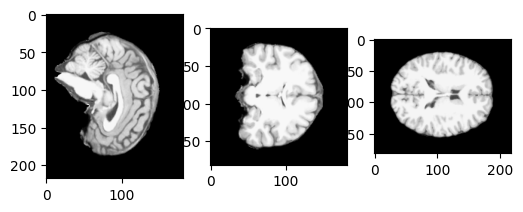

(metatensor(0.), metatensor(141.))

In [9]:
show_brain(sample["t1n"])
(sample["t1n"].min(), sample["t1n"].max())

It makes sense, but someone may have noticed that the images are not normalised.
This is an usual step in every DL pipeline. So let's do it from now.

Normalization helps making gradients of DL models more stable, as we remove extreme values from the images and allows us to make them more similar with each other, removing some unwanted differences. We will retain individual differences, but will be easier for DL methods to handle this type of data.

In [10]:
transforms = mtr.Compose([
    mtr.ScaleIntensity(0,1)
])

ds.transform = transforms

In [11]:
ds[0]

{'t1n': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

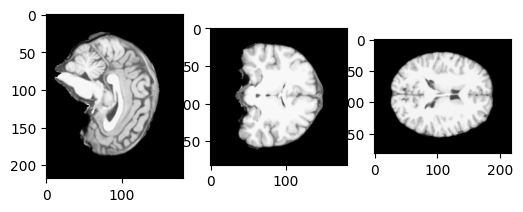

(metatensor(0.), metatensor(1.))

In [12]:
sample = ds[0]
show_brain(sample["t1n"])
(sample["t1n"].min(), sample["t1n"].max())

Nothing has changed visually speaking, but this will improve the training.

For our DL task, we will need similar evaluations as we did for regression. So, let's apply again our division

In [13]:
test_set = masterfile[masterfile["scanner"] == "GE-1.5T"]
train_set = masterfile[masterfile["scanner"] != "GE-1.5T"]

test_set["subject_id"].nunique(), train_set["subject_id"].nunique()

(66, 494)

We will use CV for our task.
Deep learning model requires heavy amount of data to learn useful patterns in our data. For training our model, using CV is mandatory since our sample size is very low.

However, for time purposes, I will show here the normal split

In [14]:
internal_df = train_set.copy()
internal_df["age_bin"] = pd.cut(train_set["age"], bins=10, labels=False, include_lowest=True)
internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)

# What we should do
# skf = StratifiedKFold(n_splits = 3, shuffle = False) 
# What I will do
train_idx, val_idx = train_test_split(np.arange(len(internal_df)), 
                                       train_size=0.2, 
                                       random_state=0,
                                       shuffle=True,
                                       stratify=internal_df["stratify_key"].values)

We will now create a very simple CNN for 3D Data. For this end, let's see the size of our mri scan

In [15]:
ds[0]["t1n"].shape

torch.Size([182, 218, 182])

The size is very large, and this can become quickly a problem for our network. Let's implement a transformation that crops this volume to a given size. We should calculate optimal crop. I did already this for you (kinda), and we can use a fixed known crop

In [16]:
transforms = mtr.Compose([
    mtr.EnsureChannelFirst(),
    mtr.SpatialCrop(
        roi_start = (6, 2, 0),
        roi_end = (173, 214, 160),
    ),
    mtr.ScaleIntensity(0,1)
])

ds.transform = transforms

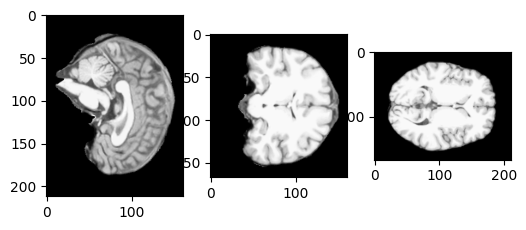

torch.Size([1, 167, 212, 160])

In [17]:
sample = ds[0]
show_brain(sample["t1n"])
sample["t1n"].shape

We greatly reduced the dimensionality. This will be insanely useful in training.

Let's now create a simple 3D CNN

In [18]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.AdaptiveMaxPool3d(1)
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: th.Tensor):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

network = Simple3DCNN().to(device=device)

In [19]:
# Try the network
network(ds[0]["t1n"].unsqueeze(0).to(device))

metatensor([[1.7392]], grad_fn=<AliasBackward0>)

In [20]:
optimizer = th.optim.AdamW(network.parameters(), lr=1e-3)
loss_fn = nn.L1Loss() # We are interested to minimise the MAE

Let's define our training loop and validation

In [21]:
def train_epoch(model, loader, optimizer):
    model.train()
    running = 0.0
    for batch in tqdm.tqdm(loader):
        img = batch["t1n"].to(device)
        age = batch["age"].to(device).view(-1, 1)
        pred = model(img).view(-1, 1)
        loss = loss_fn(pred, age)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * img.size(0)
    return running / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    with th.no_grad():
        losses = []
        for batch in loader:
            img = batch["t1n"].to(device)
            age = batch["age"].to(device).view(-1, 1)
            pred = model(img).view(-1, 1)
            losses.append(th.abs(pred - age).cpu().numpy())
    all_errors = np.concatenate(losses)
    return np.mean(all_errors), np.std(all_errors)

In [22]:
# for train_idx, val_idx in skf.split(train_set, internal_df["stratify_key"].values):
ds_tr = MRIDataset(
    train_set.iloc[train_idx],
    transform=transforms
)
ds_val = MRIDataset(
    train_set.iloc[val_idx],
    transform=transforms
)
train_dl = DataLoader(ds_tr, batch_size=16, 
                        shuffle=True,
                        num_workers=2,
                        pin_memory=False,
                        persistent_workers=False, 
                        prefetch_factor=None)
val_dl = DataLoader(ds_val, batch_size=16,
                        num_workers=2,
                        pin_memory=False,
                        persistent_workers=False, 
                        prefetch_factor=None)

In [ ]:
best_val_mae = np.inf

curr_epoch = 0

losses = pd.DataFrame(columns=["epoch", "tr_mae", "val_mae"])
if os.path.exists("../checkpoints/Simple3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Simple3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Simple3DCNN_results.csv")
    losses = losses[losses["epoch"] <= curr_epoch]

for epoch in range(curr_epoch+1, 200):
    tr_loss = train_epoch(network, train_dl, optimizer)
    val_mae, val_std = eval_model(network, val_dl)
    print(f'Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_mae:.3f} ± {val_std:.3f}')
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Simple3DCNN_best_model.pth')
    losses.loc[len(losses)] = {"tr_mae": tr_loss, "val_mae": val_mae, "epoch": epoch}
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Simple3DCNN_results.csv", index=False)

100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch 157: train loss 3.878, val MAE 14.423 ± 9.866


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch 158: train loss 3.705, val MAE 13.758 ± 10.413
New lowest reached: 13.758. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch 159: train loss 3.972, val MAE 14.090 ± 10.075


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch 160: train loss 5.016, val MAE 14.053 ± 10.079


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch 161: train loss 5.437, val MAE 14.060 ± 10.028


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch 162: train loss 2.998, val MAE 15.241 ± 10.349


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch 163: train loss 2.576, val MAE 15.698 ± 10.463


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch 164: train loss 2.964, val MAE 16.091 ± 10.631


100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch 165: train loss 3.868, val MAE 14.963 ± 10.245


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch 166: train loss 3.168, val MAE 15.979 ± 10.563


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch 167: train loss 4.012, val MAE 14.534 ± 10.180


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 168: train loss 3.459, val MAE 14.526 ± 10.069


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch 169: train loss 3.179, val MAE 15.957 ± 10.409


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch 170: train loss 3.573, val MAE 15.812 ± 10.283


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch 171: train loss 3.620, val MAE 14.943 ± 9.986


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 172: train loss 3.049, val MAE 15.039 ± 10.157


100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch 173: train loss 3.178, val MAE 15.101 ± 10.274


100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch 174: train loss 2.282, val MAE 14.248 ± 10.143


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch 175: train loss 5.421, val MAE 14.312 ± 9.792


100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch 176: train loss 3.232, val MAE 14.089 ± 9.864


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch 177: train loss 3.164, val MAE 14.118 ± 9.881


100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch 178: train loss 2.493, val MAE 15.168 ± 10.151


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch 179: train loss 2.090, val MAE 15.823 ± 10.482


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch 180: train loss 4.177, val MAE 15.034 ± 10.278


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch 181: train loss 2.882, val MAE 15.233 ± 10.295


100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch 182: train loss 2.457, val MAE 14.450 ± 10.139


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch 183: train loss 3.748, val MAE 14.368 ± 10.056


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 184: train loss 3.448, val MAE 14.722 ± 10.162


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch 185: train loss 3.914, val MAE 14.589 ± 10.053


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch 186: train loss 4.750, val MAE 16.967 ± 11.008


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 187: train loss 3.484, val MAE 14.197 ± 10.999


100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch 188: train loss 7.759, val MAE 14.829 ± 10.101


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 189: train loss 4.376, val MAE 16.322 ± 10.594


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch 190: train loss 4.406, val MAE 18.248 ± 11.690


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 191: train loss 5.264, val MAE 15.302 ± 10.334


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch 192: train loss 5.152, val MAE 15.144 ± 10.021


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch 193: train loss 4.431, val MAE 14.273 ± 9.662


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch 194: train loss 4.191, val MAE 14.861 ± 9.955


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch 195: train loss 3.107, val MAE 16.749 ± 10.925


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 196: train loss 11.082, val MAE 17.955 ± 11.494


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 197: train loss 4.455, val MAE 14.780 ± 9.769


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch 198: train loss 3.717, val MAE 14.896 ± 9.720


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 199: train loss 3.054, val MAE 14.775 ± 9.805


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch 200: train loss 3.826, val MAE 15.889 ± 10.440


This requires some time, so I did it for you. Let's load the model

In [11]:
if os.path.exists("../checkpoints/Simple3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Simple3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Simple3DCNN_results.csv")

    print(state_dict)

NameError: name 'network' is not defined

In [ ]:
test_ds = MRIDataset(
    test_set,
    transform=transforms
)

test_dl = DataLoader(test_ds, batch_size=16,
                        num_workers=1,
                        pin_memory=True,
                        persistent_workers=False, 
                        prefetch_factor=None)

test_mae, test_std = eval_model(network, test_dl)
print(f'Test MAE {test_mae:.3f} ± {test_std:.3f}')

Test MAE 21.127 ± 12.286


When testing our model on the external dataset, we see we got very bad results compared to a classical regression.
Why is this the case?

Let's look at the plot of the losses

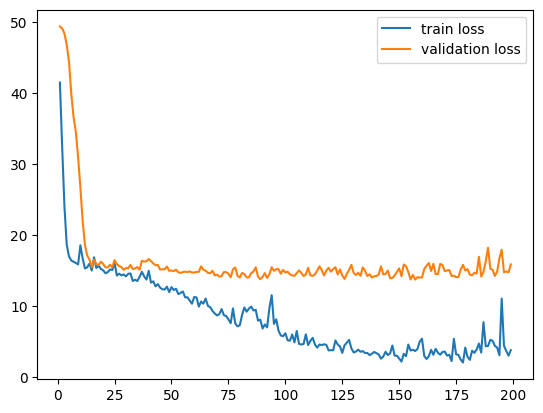

In [34]:
vec_losses = losses[["epoch", "tr_mae", "val_mae"]].values

plt.plot(vec_losses[:, 0], vec_losses[:, 1], label="train loss")
plt.plot(vec_losses[:, 0], vec_losses[:, 2], label="validation loss")
plt.legend()
plt.show()

Our model can't reach a lower validation loss after 20/30 epochs, and it plateaues at around 16 mae. Instead, training is going down, which means it is adapting to the dataset. However, the training loss seems erratic after a certain epoch. Can we make an educated guess on why this is the case?

To deal with this problem, we need to make the network more generalisable. Let's modify it a bit:

In [ ]:
class Dropout3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(8) # We removed BatchNorm in GroupNorm favour ## nn.BatchNorm3d(8)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(16) # We removed BatchNorm in GroupNorm favour ## nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(16, 64)
        self.dropout = nn.Dropout(0.3) # We add a Dropout layer for enhanced generalibility
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: th.Tensor):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

network = Dropout3DCNN().to(device=device)
optimizer = th.optim.AdamW(network.parameters(), lr=1e-3)
loss_fn = nn.L1Loss() # We are interested to minimise the MAE

In [ ]:
best_val_mae = np.inf

curr_epoch = 0

losses = pd.DataFrame(columns=["epoch", "tr_mae", "val_mae"])
if os.path.exists("../checkpoints/Dropout3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Dropout3DCNN_results.csv")
    losses = losses[losses["epoch"] <= curr_epoch]

for epoch in range(curr_epoch+1, 200):
    tr_loss = train_epoch(network, train_dl, optimizer)
    val_mae, val_std = eval_model(network, val_dl)
    print(f'Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_mae:.3f} ± {val_std:.3f}')
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Dropout3DCNN_best_model.pth')
    losses.loc[len(losses)] = {"tr_mae": tr_loss, "val_mae": val_mae, "epoch": epoch}
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Dropout3DCNN_results.csv", index=False)

100%|██████████| 7/7 [03:29<00:00, 29.93s/it]


Epoch 2: train loss 49.268, val MAE 49.421 ± 16.289
New lowest reached: 49.421. Saving checkpoint


100%|██████████| 7/7 [02:40<00:00, 22.90s/it]


Epoch 3: train loss 49.115, val MAE 49.316 ± 16.289
New lowest reached: 49.316. Saving checkpoint


100%|██████████| 7/7 [03:06<00:00, 26.68s/it]


Epoch 4: train loss 48.971, val MAE 49.159 ± 16.290
New lowest reached: 49.159. Saving checkpoint


100%|██████████| 7/7 [03:04<00:00, 26.31s/it]


Epoch 5: train loss 48.767, val MAE 48.926 ± 16.292
New lowest reached: 48.926. Saving checkpoint


100%|██████████| 7/7 [03:23<00:00, 29.05s/it]


Epoch 6: train loss 48.555, val MAE 48.649 ± 16.293
New lowest reached: 48.649. Saving checkpoint


100%|██████████| 7/7 [03:22<00:00, 29.00s/it]


Epoch 7: train loss 48.298, val MAE 48.346 ± 16.293
New lowest reached: 48.346. Saving checkpoint


100%|██████████| 7/7 [03:09<00:00, 27.12s/it]


Epoch 8: train loss 48.017, val MAE 47.996 ± 16.293
New lowest reached: 47.996. Saving checkpoint


100%|██████████| 7/7 [03:18<00:00, 28.30s/it]


Epoch 9: train loss 47.698, val MAE 47.535 ± 16.294
New lowest reached: 47.535. Saving checkpoint


100%|██████████| 7/7 [03:21<00:00, 28.72s/it]
